In [53]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

In [54]:
SAVE_DIR = 'media/'
%mkdir -p /media/final
X_LIM = (-2, 0.75)
Y_LIM = (-1.25, 1.25)

mkdir: /media: Read-only file system


In [55]:
# Checking if a point is part of the mandelbrot set
@jit(nopython=True)
def mandelbrot(z, max_iter):
    c = z
    for i in range(max_iter):
        if np.abs(z) > 2:
            return i
        z = z*z + c
    return max_iter

# Utility to calculate statistics of generated set
def mandelbrot_statistics(c_points, counts, method):
    total_area = abs(X_LIM[0] - X_LIM[1])*abs(Y_LIM[0] - Y_LIM[1])
    max_iter = np.max(counts)
    mandelbrot_ratio = np.count_nonzero(counts == max_iter) / counts.size
    mandelbrot_area = total_area * mandelbrot_ratio
    print(f'Mandelbrot area: {mandelbrot_area} using {method} method with {max_iter} evaluations and {len(counts):.1e} samples')

# Utility for plotting
def plot_mandelbrot(c_points, counts, method, max_iter=250, save=True, show=True):
    N = int(np.sqrt(len(counts)))
    match(method):
        case 'fixed':
            image_data = counts.reshape(N, N)
            plt.imshow(image_data, cmap='hot', extent=[*X_LIM, *Y_LIM])
        case 'monte-carlo':
            image_data, _, _ = np.histogram2d(x=c_points.imag, y=c_points.real, bins=N, weights=counts)
            plt.imshow(image_data, cmap='hot', extent=[*X_LIM, *Y_LIM])
        case _:
            raise ValueError('Invalid argument, method does not exist.')
    plt.colorbar(shrink=0.85, label='# iterations')
    plt.axis('off')
    if save:
        plt.savefig(f'mandelbrot_{method}_{max_iter}_{N}.png', dpi=300)
    if show:
        plt.show()

# Generating mandelbrot set on a fixed grid
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_fixed(max_iter=250, size=1_000):
    real_parts = np.linspace(*X_LIM, size)
    imag_parts = np.linspace(*Y_LIM, size)
    c_points = np.zeros((size, size), dtype=np.complex128)
    counts = np.zeros((size, size), dtype=np.int32)
    for i in prange(size):
        for j in prange(size):
            z = complex(real_parts[j], imag_parts[i])
            c_points[i, j] = z
            counts[i, j] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

# Generating mandelbrot using monte-carlo randomly sampled points
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_mc(max_iter=250, n_points=1_000_000):
    real_parts = np.random.uniform(low=X_LIM[0], high=X_LIM[1], size=n_points)
    imag_parts = np.random.uniform(low=Y_LIM[0], high=Y_LIM[1], size=n_points)
    c_points = np.stack((real_parts, imag_parts), axis=-1).view(np.complex128)
    counts = np.zeros((n_points), dtype=np.int32)
    for i in prange(n_points):
        z = c_points[i]
        counts[i] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

Mandelbrot area: 1.5274874999999999 using monte-carlo method with 250 evaluations and 1.0e+06 samples
Mandelbrot area: 1.51859125 using fixed method with 250 evaluations and 1.0e+06 samples
(1000000,) (1000000,) (1000000,)


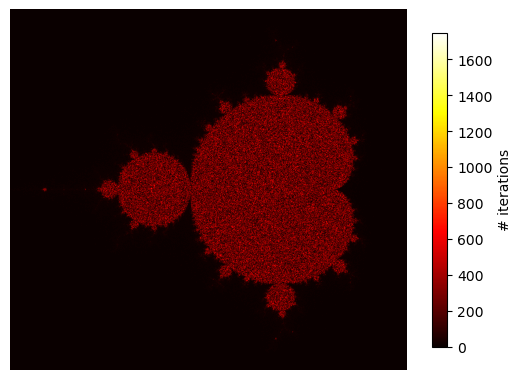

In [56]:
points_mc, counts_mc = mandelbrot_parallel_mc()
mandelbrot_statistics(points_mc, counts_mc, method='monte-carlo')
points_fixed, counts_fixed = mandelbrot_parallel_fixed()
mandelbrot_statistics(points_fixed, counts_fixed, method='fixed')
plot_mandelbrot(points_mc, counts_mc, method='monte-carlo')